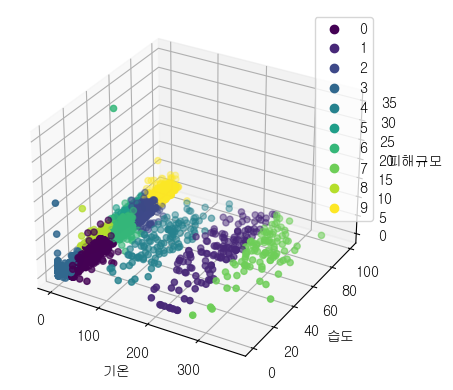

                 기온         습도      피해규모
cluster                                 
0         22.193375  23.359015  1.112481
1        210.103455  53.427586  1.110345
2         25.360466  64.877075  1.103405
3          4.563953   1.784157  1.140262
4        105.558334  51.383335  1.058333
5          8.781169  58.580444  1.104501
6         22.733829  47.765007  1.119591
7        279.137268  65.343140  1.078431
8          8.536586  34.211166  1.120026
9         21.182941  83.050591  1.147647


In [89]:
from matplotlib import font_manager, rc

from util.preprocessing import calc_damage_scale, count_days, extract_cost, extract_facility, extract_month, extract_population, parse_num_of_people, str_to_median
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load data
data = pd.read_csv('./data/data/output.csv')

# Select columns for clustering
allColumns = data.columns
columns = ['발생일시', '기상상태', '시설물 종류', '사망자수(명)', '부상자수(명)', '공사비',
           '공사기간', '공정률', '작업자수', '설계안전성검토']
col = ['사망자수(명)', '부상자수(명)', '기상상태']
data = data.drop(allColumns.drop(columns), axis=1)
# data = data.drop(allColumns.drop(col), axis=1)

data = data.dropna()
# data = data.fillna('날씨 : 맑음 기온 : 0℃ 습도 : 0%')
#범주형 데이터를 수치형 데이터로 인코딩

data['사망자수(명)'] = data['사망자수(명)'].apply(parse_num_of_people)
data['부상자수(명)'] = data['부상자수(명)'].apply(parse_num_of_people)
data['발생일시'] = data['발생일시'].apply(extract_month)
data['시설물 종류'] = data['시설물 종류'].apply(extract_facility)
data['공사기간'] = data['공사기간'].apply(count_days)
data['공정률'] = data['공정률'].apply(str_to_median)
data['작업자수'] = data['작업자수'].apply(extract_population)
data['공사비'] = data['공사비'].apply(extract_cost)
data['피해규모'] = data.apply(calc_damage_scale, axis=1)

# 기상 상태 컬럼 분리
data[['날씨', '기온', '습도']] = data['기상상태'].str.extract('날씨 : (\S+)기온 : (\d+)℃습도 : (\d+)%')
# X = data[['피해규모', '작업자수', '공사비']]
X = data[['기온', '습도', '피해규모']] #클러스터링 잘됨
# X = data[['공사비', '작업자수', '피해규모']] #나름 잘됨
# cc = df[['공사기간', '공정률', '작업자수', '공사비']]
# X = data[['발생일시', '기온', '피해규모']] #발생일시가 불연속적이라 띄엄띄엄

# 무한대 값을 NaN으로 대체
X = X.replace([np.inf, -np.inf], np.nan)

# NaN 값을 0으로 대체
X = X.fillna(0)

X = X.astype('float32')
# Standardize data
# X = (X - np.mean(X)) / np.std(X)

# Cluster using k-means algorithm
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)
X['cluster'] = kmeans.labels_
# Visualize clustering result
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X.iloc[:, 0], X.iloc[:, 1], X.iloc[:, 2], c=kmeans.labels_)
X.head()
ax.set_xlabel('기온')
ax.set_ylabel('습도')
ax.set_zlabel('피해규모')
plt.legend(handles=scatter.legend_elements()[0], labels=[0,1,2,3,4,5,6,7,8,9])
plt.show()

#클러스터링 변수인 clusters 값을 원본 데이터인 'cc'내에 넣기 
X['cluster'] = kmeans.labels_

#cluster를 기준으로 데이터 개수 세기
# print(X.groupby('cluster').count())
#그룹별 특징을 알아보자! -그룹별 평균값
print(X.groupby('cluster').mean())



In [90]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from util.preprocessing import parse_num_of_people, extract_month, extract_facility, extract_ratio, extract_population, extract_cost, count_days, calc_damage_scale, extract_middle_class, str_to_median
import re
from dateutil import parser
import numpy as np

df = pd.read_csv('./data/data/output.csv')
#필요 없는 특성 제거

allColumns = df.columns
params = ['발생일시','공공/민간 구분', '기상상태', '시설물 종류', '사망자수(명)', '부상자수(명)', '공사비', '공사기간', '공정률', '작업자수', '설계안전성검토', '공종']

df = df.drop(allColumns.drop(params), axis=1)

df = df.dropna()

df['공종'] = df['공종'].apply(extract_middle_class)

#범주형 데이터를 수치형 데이터로 인코딩

df['사망자수(명)'] = df['사망자수(명)'].apply(parse_num_of_people)
df['부상자수(명)'] = df['부상자수(명)'].apply(parse_num_of_people)
df['발생일시'] = df['발생일시'].apply(extract_month)
df['시설물 종류'] = df['시설물 종류'].apply(extract_facility)
df['공사기간'] = df['공사기간'].apply(count_days)
df['공정률'] = df['공정률'].apply(str_to_median)
df['작업자수'] = df['작업자수'].apply(extract_population)
df['공사비'] = df['공사비'].apply(extract_cost)
df['피해규모'] = df.apply(calc_damage_scale, axis=1)

# 기상 상태 컬럼 분리
df[['날씨', '기온', '습도']] = df['기상상태'].str.extract('날씨 : (\S+)기온 : (\d+)℃습도 : (\d+)%')
df = df.drop(['기상상태'], axis=1)


df = df.dropna()

cc = df[['발생일시', '공사기간', '공정률', '작업자수', '공사비', '기온', '습도']] #퍼져있음
# cc = df[['발생일시', '공사기간', '공정률', '작업자수', '공사비']] #더 퍼져있음
# cc = df[['기온', '습도', '발생일시']]
# cc = df[['공사기간', '작업자수', '공사비']]
cc.head()

,발생일시,공사기간,공정률,작업자수,공사비,기온,습도
0,3,449,0.645,19,7.500000e+09,17,54
1,3,422,0.345,19,3.500000e+09,14,50
2,3,333,0.100,19,7.500000e+09,15,85
4,3,593,0.245,49,1.750000e+10,20,60
5,3,387,0.145,99,7.500000e+09,15,30


In [91]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#표준화
sc = StandardScaler()
cc_scaled = sc.fit_transform(cc)
pd.DataFrame(cc_scaled)

#cc_scaled 데이터를 넣어 클러스터링
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit(cc_scaled)
print(cc_scaled)

#클러스터링 변수인 clusters 값을 원본 데이터인 'cc'내에 넣기 
cc['cluster'] = clusters.labels_
cc.head()

#cluster를 기준으로 데이터 개수 세기
print(cc.groupby('cluster').count())
#그룹별 특징을 알아보자! -그룹별 평균값
cc.groupby('cluster').mean()

[[-1.24420346 -0.59880253  0.48539432 ... -0.42807739 -0.19693621
   0.09893905]
 [-1.24420346 -0.64767765 -0.55630569 ... -0.74247473 -0.28365942
  -0.08866072]
 [-1.24420346 -0.80878455 -1.40702736 ... -0.42807739 -0.25475168
   1.5528373 ]
 ...
 [-0.30463303 -1.25047089 -0.90353902 ... -1.00578249  0.17886437
  -0.97975965]
 [-0.30463303 -1.21426709 -0.20907235 ... -0.42807739  0.20777211
   0.61483843]
 [-0.30463303 -0.25667663 -0.20907235 ...  0.94741094  0.17886437
  -1.49565902]]
         발생일시  공사기간   공정률  작업자수   공사비    기온    습도
cluster                                          
0        2482  2482  2482  2482  2482  2482  2482
1        2288  2288  2288  2288  2288  2288  2288
2        3557  3557  3557  3557  3557  3557  3557
3         232   232   232   232   232   232   232
4        1872  1872  1872  1872  1872  1872  1872


C:\Users\82105\AppData\Local\Temp\ipykernel_14496\2950778286.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc['cluster'] = clusters.labels_


,발생일시,공사기간,공정률,작업자수,공사비
cluster,,,,,
0,3.470185,653.793715,0.440995,71.099114,8.645266e+09
1,7.347465,1145.734703,0.587485,376.786276,1.128313e+10
2,8.981445,498.993534,0.532548,38.440540,5.992142e+09
3,7.357759,784.866379,0.490862,132.267241,1.325733e+10
4,7.293803,1032.521368,0.439629,136.379274,3.385684e+10


In [92]:
from sklearn.decomposition import PCA
X = cc_scaled.copy()

#객체
pca = PCA(n_components=2)

#적용
pca.fit(X)
x_pca = pca.transform(X)
x_pca

#x_pca를 보기 쉽게 데이터프레임으로 만들기
pca_df = pd.DataFrame(x_pca)
pca_df['cluster'] = cc['cluster'] 
pca_df.head()

,0,1,cluster
0,-0.924557,-0.690872,0.0
1,-1.158145,-1.044446,0.0
2,-1.060842,-0.158857,0.0
3,-0.266405,-0.752862,NaN
4,-0.791952,-1.752800,0.0


c:\Users\82105\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


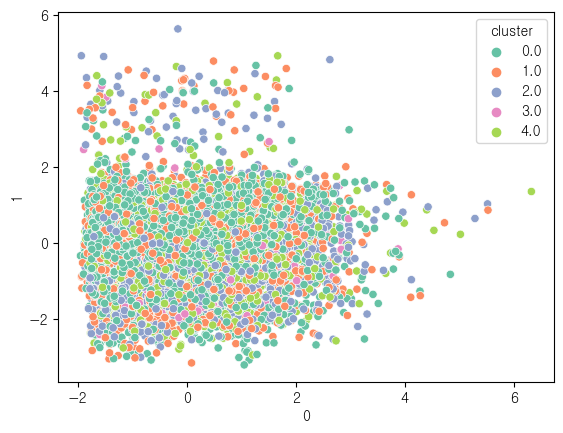

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
axs = plt.subplots()
axs = sns.scatterplot(0, 1, hue='cluster', data=pca_df, palette='Set2')

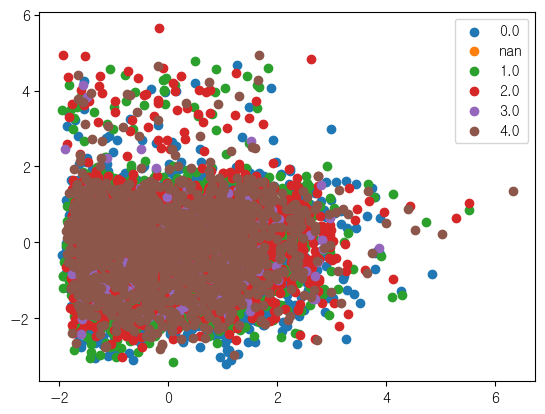

In [94]:
for i in sorted(pca_df['cluster'].unique()):
    tmp = pca_df.loc[pca_df['cluster'] == i] #해당하는 클러스터 번호일 때 그림을 그리고, for문 실행하며 위에 덧그림 
    plt.scatter(tmp[0], tmp[1])
    plt.legend(sorted(pca_df['cluster'].unique()))

In [95]:
#앞서 만든 cc에서 지속/탈퇴회원 여부를 알아야 하므로 'is_deleted' 열을 추가한다. (이 열은 c 데이터에 있으므로 둘을 조인)
cc_join= pd.concat([cc, df], axis=1)
cc_join.head()

newdf = cc_join.groupby(['cluster','피해규모'], as_index=False).count()[['cluster', '피해규모']]
newdf

,cluster,피해규모
0,0,0.0
1,0,1.0
2,0,2.0
3,0,3.0
4,0,4.0
5,0,5.0
6,0,6.0
7,0,35.0
8,1,0.0
9,1,1.0


In [96]:
#위의 newdf에서 cluster별 탈퇴 및 미탈퇴회원 비율을 for문으로 뽑아보자.
de0 = (newdf['피해규모']==0) #지속회원
de1 = (newdf['피해규모']==1) #탈퇴회원

for i in range(0, 4):
    tmp = (newdf['cluster']==i)
    print('Cluster '+ str(i) + '의 탈퇴회원 비율은 ' + str(round((newdf.loc[(tmp & de1),  ''].sum() / newdf.loc[tmp, 'customer_id'].sum())*100, 2)) + '%')
    print('Cluster '+ str(i) + '의 지속회원 비율은 ' + str(round((newdf.loc[(tmp & de0),  'customer_id'].sum() / newdf.loc[tmp, 'customer_id'].sum())*100, 2)) + '%')
    print(' ')

KeyError: ''